In [12]:
import os
import glob
import numpy as np
from scipy import ndimage
from IPython.display import Audio
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
from nnmnkwii.preprocessing.f0 import interp1d
from nnmnkwii.util import apply_delta_windows
import pandas as pd

In [2]:
data_folder = '/home/beiming/Desktop/Parsed_data'
group_name = 'ENF' # ENF or ENM
group_folder = os.path.join(data_folder, group_name)
subject_list = os.listdir(group_folder) 
print(subject_list)

['09ENF', '40ENF', '37ENF', '36ENF', '05ENF', '17ENF', '07ENF', '18ENF', '21ENF', '28ENF']


In [3]:
#Choose subject ID based on the print above
sub_name = '40ENF'

data_sub_folder = os.path.join(group_folder, sub_name)

WAV_path_list = os.path.join(data_sub_folder, '*' + '.wav')
WAV_path_list = glob.glob(WAV_path_list)
WAV_path_list.sort()

EMA_path_list = os.path.join(data_sub_folder, '*' + '.ema')
EMA_path_list = glob.glob(EMA_path_list)
EMA_path_list.sort()

In [4]:
import pyworld
import pysptk
import nnmnkwii

In [5]:
mgc_dim = 40
lf0_dim = 1
vuv_dim = 1
bap_dim = 1

fs = 16000

frame_period = 5
hop_length = 80
fftlen = 1024
alpha = 0.41

order = 39
frame_period = 5
windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]

file_num = len(WAV_path_list)

train_index = range(file_num - 20)
valid_index = range(file_num - 20, file_num - 10)
test_index = range(file_num - 10, file_num)

In [6]:
def collect_features(wav_path, fs, frame_period, order):
  
    x, sr = librosa.load(wav_path, sr = fs)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    bap = pyworld.code_aperiodicity(aperiodicity, fs)
    mgc = pysptk.sp2mc(spectrogram, order=order,
                       alpha=pysptk.util.mcepalpha(fs))
    f0 = f0[:, None]
    lf0 = f0.copy()
    nonzero_indices = np.nonzero(f0)
    lf0[nonzero_indices] = np.log(f0[nonzero_indices])
    vuv = (lf0 != 0).astype(np.float32)
    lf0 = interp1d(lf0, kind="slinear")
    
    lf0 = f0.copy()
    nonzero_indices = np.nonzero(f0)
    lf0[nonzero_indices] = np.log(f0[nonzero_indices])
    vuv = (lf0 != 0).astype(np.float32)
    lf0 = interp1d(lf0, kind="slinear")

    lf0 = lf0.reshape(lf0.shape[0],1)
    vuv = vuv.reshape(vuv.shape[0],1)

    mgc_delta = apply_delta_windows(mgc, windows)
    lf0_delta = apply_delta_windows(lf0, windows)
    bap_delta = apply_delta_windows(bap, windows)
    
    features = np.hstack((mgc, lf0, vuv, bap))

    delta_features = np.hstack((mgc_delta, lf0_delta, vuv, bap_delta))
    
    return features, delta_features

In [7]:
Valid_MV = {}
Valid_WAV = {}

index = 0

for i in valid_index:
  
  MV = np.loadtxt(EMA_path_list[i])
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Valid_MV[index] = MV_delta
  Valid_WAV[index] = WAV_delta
  
  index = index + 1  

/home/beiming/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [8]:
Test_MV = {}
Test_WAV = {}

index = 0

for i in test_index:
  
  MV = np.loadtxt(EMA_path_list[i])
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Test_MV[index] = MV_delta
  Test_WAV[index] = WAV_delta
  
  index = index + 1  

In [9]:
Train_MV = {}
Train_WAV = {}

index = 0

for i in train_index:
  
  MV = np.loadtxt(EMA_path_list[i])
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Train_MV[index] = MV_delta
  Train_WAV[index] = WAV_delta
  
  index = index + 1 

In [102]:
Train_MV_block = np.concatenate([Train_MV[x] for x in Train_MV], 0).astype(np.float32)
Train_WAV_block = np.concatenate([Train_WAV[x] for x in Train_WAV], 0)

Valid_MV_block = np.concatenate([Valid_MV[x] for x in Valid_MV], 0).astype(np.float32)
Valid_WAV_block = np.concatenate([Valid_WAV[x] for x in Valid_WAV], 0)

Test_MV_block = np.concatenate([Test_MV[x] for x in Test_MV], 0).astype(np.float32)
Test_WAV_block = np.concatenate([Test_WAV[x] for x in Test_WAV], 0)

In [107]:
MV_min =  Valid_WAV_block.min(axis = 0)

print(MV_min)

[ -8.45317617  -1.43869753  -1.40133177  -0.91553367  -1.36119951
  -1.2342245   -0.98324501  -0.84227182  -0.9827366   -0.61612525
  -0.70049606  -0.32463608  -0.72532257  -0.3030624   -0.73848159
  -0.57451203  -0.5706244   -0.25942811  -0.45026163  -0.31783513
  -0.36467558  -0.3512658   -0.32229466  -0.28083412  -0.34260307
  -0.22159386  -0.41367663  -0.14126591  -0.39998019  -0.11507006
  -0.35435895  -0.105603    -0.32258468  -0.13701079  -0.28782419
  -0.11760344  -0.27242826  -0.17335627  -0.26084472  -0.13894993
  -4.02464621  -0.9961711   -0.88359734  -0.66122401  -0.61288579
  -0.47679041  -0.42883319  -0.42827119  -0.3386081   -0.3637134
  -0.32109789  -0.28766729  -0.26863266  -0.27161741  -0.21104393
  -0.25045946  -0.24151895  -0.21077762  -0.18880728  -0.26090646
  -0.18271981  -0.17719293  -0.15841207  -0.15502419  -0.15278452
  -0.14426764  -0.1223256   -0.1328288   -0.16102116  -0.16878574
  -0.125553    -0.12097724  -0.1347071   -0.12352239  -0.11737935
  -0.147219

In [64]:
mean_in = Train_MV_block.mean(axis = 0)
std_in = Train_MV_block.std(axis = 0)
Train_MV_block = (Train_MV_block - mean_in) / std_in 
Valid_MV_block  = (Valid_MV_block - mean_in) / std_in
Test_MV_block = (Test_MV_block - mean_in) / std_in

In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [96]:
def build_model():
    
    model = keras.Sequential([
        layers.Dense(512, activation = tf.nn.tanh, input_shape = (Train_MV_block.shape[1],), use_bias = True),
        layers.Dense(512, activation = tf.nn.relu, use_bias = True),
        layers.Dense(512, activation = tf.nn.relu, use_bias = True),
        layers.Dense(512, activation = tf.nn.relu, use_bias = True),
        layers.Dense(512, activation = tf.nn.relu, use_bias = True),
        layers.Dense(Train_WAV_block.shape[1])
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse'])
    
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 512)               32768     
_________________________________________________________________
dense_91 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_92 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_93 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_94 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_95 (Dense)             (None, 127)               65151     
Total params: 1,148,543
Trainable params: 1,148,543
Non-trainable params: 0
_________________________________________________________________


In [97]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print(' ')
        print('.', end = ' ')

EPOCHS = 10

history = model.fit(Train_MV_block, Train_WAV_block, batch_size = 1024, epochs = EPOCHS, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [PrintDot()])

 
. . . . . . . . . . 

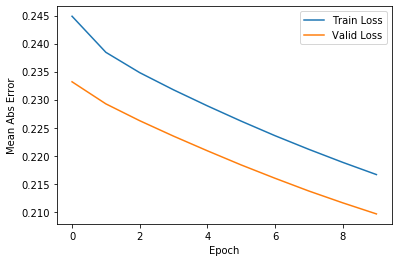

In [98]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']), label = 'Valid Loss')
    plt.legend()
    
plot_history(history)

In [99]:
test_prediction = model.predict(Test_MV_block)
print(test_prediction)

[[-1.4287232e+00  1.1326190e+00  2.2360833e-01 ... -1.3972093e+00
   1.9563080e-03 -6.6067209e-04]
 [-1.4287232e+00  1.1326190e+00  2.2360833e-01 ... -1.3972093e+00
   1.9563080e-03 -6.6067209e-04]
 [-1.4287232e+00  1.1326190e+00  2.2360833e-01 ... -1.3972093e+00
   1.9563080e-03 -6.6067209e-04]
 ...
 [-1.4287232e+00  1.1326190e+00  2.2360833e-01 ... -1.3972093e+00
   1.9563080e-03 -6.6067209e-04]
 [-1.4287232e+00  1.1326190e+00  2.2360833e-01 ... -1.3972093e+00
   1.9563080e-03 -6.6067209e-04]
 [-1.4287232e+00  1.1326190e+00  2.2360833e-01 ... -1.3972093e+00
   1.9563080e-03 -6.6067209e-04]]


In [100]:
weights, biases = model.layers[4].get_weights()
print(weights, biases)

[[ 0.04908007  0.03210932  0.05842675 ... -0.02810086 -0.00077937
   0.00801255]
 [ 0.00362415  0.02458131 -0.04194108 ...  0.00667746 -0.01029465
  -0.0262073 ]
 [ 0.02652993  0.03185794 -0.04082315 ... -0.04728645  0.04599001
  -0.03148768]
 ...
 [-0.01468094  0.03710605  0.06202573 ... -0.07009165 -0.01769422
   0.06297977]
 [ 0.04328498  0.03461796  0.07342241 ... -0.01635357  0.05494667
   0.05217817]
 [-0.00209663 -0.05780834 -0.02342242 ...  0.0196707  -0.0348407
  -0.014496  ]] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [101]:
print(biases.shape)

(512,)
